In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [4]:
class Multi_Func(nn.Module):
    def __init__(self, functions, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions  # [[function, (...)], [# params, (...)]]
        self.x_data = x_data
        self.input_channels = input_channels
        self.params = sum(self.functions[1])

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128), #28, 16/128
            nn.SELU(),
            nn.Linear(128, 64), #16/128, 8/64
            nn.SELU(),
            nn.Linear(64, self.params), #8/64
        )

    def forward(self, x, n=-1):
        target = x.squeeze(dim=2)
        x = torch.swapaxes(x, 1, 2).to(self.device)
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        loss_func = nn.MSELoss()
        target_range = torch.max(target) - torch.min(target)
        target_range = torch.clamp(target_range, min=1e-6)

        start_index = 0
        losses = []
        outputs = []
        
        for f in range(len(self.functions[0])):
            output = self.functions[0][f](
                embedding[:, start_index:start_index+self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(device)
            outputs.append(output)
            loss = loss_func(output, target) / target_range
            losses.append(loss)
            start_index += self.functions[1][f]        
        best_index = torch.argmin(torch.tensor(losses))
        best_func = self.functions[0][best_index]
        best_loss, best_out = losses[best_index], outputs[best_index]

        return best_out, best_loss, best_func, outputs, losses



In [5]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), sample_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.sample_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return torch.sum(out,dim=3)


In [6]:
class Sin_func:
    def __init__(self, x, range=[-1,1], size=(1, 1), sample_size=1000, device="cuda"):
        self.x = x
        self.range = range
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        amp = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        freq = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        phase = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        
        params = torch.stack((amp, freq, phase))
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y =  params[:,0,0,0] * torch.sin(2 * torch.pi * params[:,0,1,0] * x + params[:,0,2,0])
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)  
        out[:, :, 0, 0] = torch.transpose(y, 0, 1)
        return torch.sum(out, dim=3)

In [7]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 3:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)
    
def sin_function(params, x, device):
    x = x.to(device)
    if params.size(1) == 3:
        amplitude = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        frequency = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        phase = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return amplitude * torch.sin(2 * torch.pi * frequency * x + phase)
    else:
        return torch.zeros_like(x)

In [ ]:
def generate_data(x, num_params, function, range=[-1,1], sample_size=1000, device='cuda'):
    hold = []
    for _ in range(num_params):
        hold.append(torch.rand(sample_size,1,1)*(range[0]-range[1])+range[1])
    
    params = torch.stack(hold)
    params = torch.atleast_2d(params)
    params = torch.transpose(params, 0, 1)
    params = torch.transpose(params, 1, 2)
    params = params.to(device)
    
    x = torch.cat(params.shape[0] * x).reshape(params.shape[0], -1).to(device)
    x = torch.transpose(x, 0, 1).to(device)
    y = function(params, device)
    out = torch.zeros((params.shape[0], x.shape[0],1, 1)).to(device)  
    out[:, :, 0, 0] = torch.transpose(y, 0, 1)
    return torch.sum(out, dim=3)

In [8]:
sample_size = 10000
batch_size = 500
data_range = [-1, 1]
num_funcs = 4

x_values = torch.linspace(data_range[0], data_range[1], 1000)

linear = Polynomial_func(x=x_values, range=data_range, degree=1, sample_size=sample_size, device=device)
lin_full = linear.generate()
lin_data = DataLoader(lin_full, batch_size=batch_size)

quad = Polynomial_func(x=x_values, range=data_range, degree=2, sample_size=sample_size, device=device)
quad_full = quad.generate()
quad_data = DataLoader(quad_full, batch_size=batch_size)

cube = Polynomial_func(x=x_values, range=data_range, degree=3, sample_size=sample_size, device=device)
cube_full = cube.generate()
cube_data = DataLoader(cube_full, batch_size=batch_size)

sin = Sin_func(x=x_values, range=data_range, sample_size=sample_size, device=device)
sin_full = sin.generate()
sin_data = DataLoader(sin_full, batch_size=batch_size)


# all_data = [cube_data, quad_data, lin_data, sin_data]
all_data = DataLoader(torch.vstack((lin_full, quad_full, cube_full, sin_full)), batch_size=batch_size, shuffle=True)

In [244]:
torch.vstack((lin_full, quad_full, cube_full, sin_full)).shape

torch.Size([40000, 1000, 1])

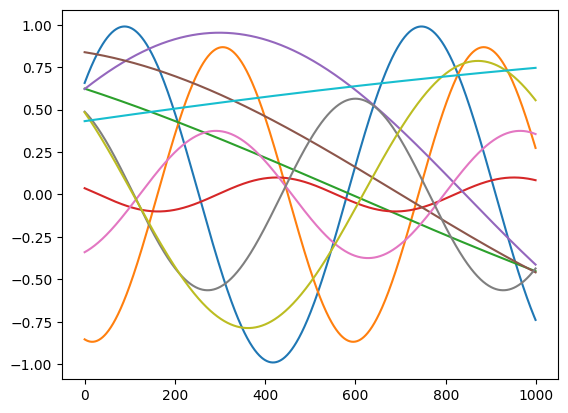

In [239]:
for i in range(10):
    r = np.random.randint(sample_size)
    #plt.plot(lin_full[r, :, 0].detach().cpu().numpy(), "-")
    #plt.plot(quad_full[r, :, 0].detach().cpu().numpy(), "-")
    #plt.plot(cube_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(sin_full[r, :, 0].detach().cpu().numpy(), "-")


In [28]:
functions = [[linear_function, quadratic_function, cubic_function, sin_function], [2,3,4,3]]
model = Multi_Func(functions=functions, x_data=x_values, input_channels=1, device=device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [29]:
epochs = 50
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()

    #data = all_data[0]
    #for n in range(num_funcs):
    #    if epoch % (n+1) == 0:
    #        data = all_data[n-1]

    for train_batch in all_data:
        train_batch = train_batch.to(device)
        target_batch = train_batch.squeeze(2).to(device)
        optimizer.zero_grad()
        best_out,_,_,_,_ = model(train_batch)
        loss = loss_func(best_out,target_batch)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")
    #for name, param in model.named_parameters():
    #    if param.grad is not None:
    #        print(f"Gradient for {name}: {param.grad}")

epoch : 0/50, loss = 0.06140695
--- 2.111999034881592 seconds ---
epoch : 1/50, loss = 0.01107416
--- 2.070864677429199 seconds ---
epoch : 2/50, loss = 0.00841810
--- 1.985459804534912 seconds ---
epoch : 3/50, loss = 0.00768316
--- 1.966728925704956 seconds ---
epoch : 4/50, loss = 0.00739104
--- 2.0997822284698486 seconds ---
epoch : 5/50, loss = 0.00750756
--- 2.1066439151763916 seconds ---
epoch : 6/50, loss = 0.00737615
--- 2.0961835384368896 seconds ---
epoch : 7/50, loss = 0.00739206
--- 2.021955966949463 seconds ---
epoch : 8/50, loss = 0.00733285
--- 2.0019521713256836 seconds ---
epoch : 9/50, loss = 0.00737689
--- 2.12243914604187 seconds ---
epoch : 10/50, loss = 0.00712824
--- 2.0856564044952393 seconds ---
epoch : 11/50, loss = 0.00712176
--- 2.0247223377227783 seconds ---
epoch : 12/50, loss = 0.00711887
--- 2.086991548538208 seconds ---
epoch : 13/50, loss = 0.00711636
--- 2.0846807956695557 seconds ---
epoch : 14/50, loss = 0.00711377
--- 2.184910535812378 seconds ---

In [26]:
for epoch in range(10):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()

    for train_batch in sin_data:
        train_batch = train_batch.to(device)
        target_batch = train_batch.squeeze(2).to(device)
        optimizer.zero_grad()
        best_out,_,_,_,_ = model(train_batch)
        loss = loss_func(best_out,target_batch)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

epoch : 0/50, loss = 0.08343106
--- 0.5253417491912842 seconds ---
epoch : 1/50, loss = 0.08343102
--- 0.5156006813049316 seconds ---
epoch : 2/50, loss = 0.08343096
--- 0.5363166332244873 seconds ---
epoch : 3/50, loss = 0.08343090
--- 0.5207099914550781 seconds ---
epoch : 4/50, loss = 0.08343084
--- 0.5309560298919678 seconds ---
epoch : 5/50, loss = 0.08343079
--- 0.5445513725280762 seconds ---
epoch : 6/50, loss = 0.08343073
--- 0.5340888500213623 seconds ---
epoch : 7/50, loss = 0.08343067
--- 0.5227882862091064 seconds ---
epoch : 8/50, loss = 0.08343061
--- 0.4905354976654053 seconds ---
epoch : 9/50, loss = 0.08343055
--- 0.5236842632293701 seconds ---


In [13]:
t_sample_size = 100

t_x_values = torch.linspace(-1, 1, 1000)
t_linear = Polynomial_func(x=x_values, range=[-1,1], degree=1, sample_size=t_sample_size, device=device)
t_quad = Polynomial_func(x=x_values, range=[-1,1], degree=2, sample_size=t_sample_size, device=device)
t_cube = Polynomial_func(x=x_values, range=[-1,1], degree=3, sample_size=t_sample_size, device=device)
t_sin = Sin_func(x=t_x_values, range=data_range, sample_size=t_sample_size, device=device)

t_lin_full = t_linear.generate()
t_quad_full = t_quad.generate()
t_cube_full = t_cube.generate()
t_sin_full = t_sin.generate()

t_data = torch.vstack([t_lin_full, t_quad_full, t_cube_full, t_sin_full])

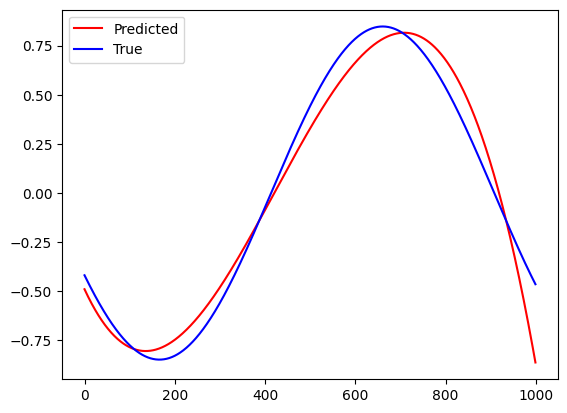

In [47]:
model.eval
best_out, best_loss, best_func, outputs, losses = model(t_sin_full)
rand = np.random.randint(0, t_sample_size)
plt.plot(best_out[rand].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(t_sin_full[rand].detach().cpu().numpy(), "b", label='True')
plt.legend();

In [276]:
best_out, best_loss, best_func, outputs, losses = model(t_sin_full)
print(best_func)
print(losses)
print(best_loss)
plt.hist(np.array(losses).detach().cpu().numpy(), 100)

<function sin_function at 0x7fb9e5689ee0>
[tensor(0.2088, device='cuda:3', grad_fn=<MseLossBackward0>), tensor(0.1949, device='cuda:3', grad_fn=<MseLossBackward0>), tensor(0.3741, device='cuda:3', grad_fn=<MseLossBackward0>), tensor(0.1003, device='cuda:3', grad_fn=<MseLossBackward0>)]
tensor(0.1003, device='cuda:3', grad_fn=<MseLossBackward0>)


TypeError: can't convert cuda:3 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.